(section:theodorsen_implementation)=
# Implementation of the linearised Theodorsen model

The purpose of this notebook is to showcase and explain a linear time-independent (LTI) state-space representation of Theodorsen's unsteady lift model, along with a demonstrative implementation using the Python Control Systems Library (https://python-control.readthedocs.io/en/0.9.1/). The LTI representation has been reproduced from {cite}`brunton2013empirical`. While it is not exact, since the Theodorsen model cannot be represented by an LTI model with a finite set of states {cite}`peters2008two`, it allows computing unsteady lift responses to arbitrary inputs with a good degree of accuracy, as demonstrated in {cite}`brunton2013empirical`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import control  # https://python-control.readthedocs.io/en/0.9.1/

## State-space representation of LTI systems
An LTI system with input $u(t) \in \mathbb{R}^l$ and output $y(t) \in \mathbb{R}^m$ can be represented using a pair of equations. The first, a linear ODE, models the evolution of the state $x(t) \in \mathbb{R}^n$ due to its current value and the input $u(t)$:

$$\begin{equation}
\dot{x}(t) = Ax(t) + Bu(t)
\end{equation}$$

The second equation transforms the input and state of the system into the output:

$$\begin{equation}
y(t) = Cx(t) + Du(t)
\end{equation}$$

The matrices have dimensions $A_{n\times n}$, $B_{n\times l}$, $C_{m\times n}$ and $D_{m \times l}$, and together they completely represent the LTI system. A convenient way to relate their dimensions is by representing the system by a single matrix equation:
$$\begin{bmatrix}
\dot{x}\\y
\end{bmatrix}=\begin{bmatrix}
A & B\\ C & D
\end{bmatrix} \cdot \begin{bmatrix}
x\\u
\end{bmatrix}$$

It is worth noting that a state-space representation is not unique, and that the number of states can vary.

## The Theodorsen model LTI state-space approximation

### Airfoil parameters

The studied airfoil has a half-chord length of $b$ (i.e. the chord length is $c=2b$), and is subject to a free-stream flow with a velocity of $U_\infty$. It is able to pitch around an axis located at $a$ semichords (i.e. fractions of $b$) downstream from the middle point of the airfoil, with $a=-1$ and $a=1$ being located at the leading and trailing edges, respectively.

In [2]:
a = -0.5
b = 1

Two additional aerodynamical coefficients are present — $C_1 = \pi$ is the aerodynamic coefficient corresponding to added-mass effect contribution to usteady lift ($C_L^{AM}$), while $C_2 = 2\pi$ is the quasi-static lift slope, i.e. $\partial C_L/\partial \alpha$.

In [3]:
C_1 = np.pi
C_2 = 2*np.pi

### Approximating the Theodorsen function

The full expression of the Theodorsen function is:

$$\begin{equation}
C(k) = \frac{H_1^{(2)}(k)}{H_1^{(2)}(k) + jH_0^{(2)}(k)}
\end{equation}$$

where $H_\nu^{(2)}(k)$ are Hankel functions, defined by an expression using Bessel functions, $H_\nu^{(2)}(k) - J_\nu + jY_\nu$. This formula cannot be expressed as a rational function of $k$, and consequently it cannot be represented by an LTI model with finite state. However, it is possible to approximate it with an LTI system, taking quasi-steady lift $C_L^{QS}$ as input and outputting the circulatory lift $C_L^{circ}$. This topic is explored in {cite}`brunton2013empirical`. The approximation obtained there has the form:

$$\begin{equation} \dot{\tilde{x}} = \begin{bmatrix}
-1.158 & -0.3052 & -0.02028 & -2.325\cdot 10^{-4}\\
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0\\
0 & 0 & 1 & 0\\
\end{bmatrix} \tilde{x} + \begin{bmatrix}1\\ 0\\ 0\\ 0 \end{bmatrix}\tilde{u} = \tilde{A}\tilde{x} + \tilde{B}\tilde{u}
\end{equation}$$

$$\begin{equation} \tilde{y} = \begin{bmatrix}
0.124 & 0.08667 & 0.008805 & 1.156\cdot 10^{-4}\\
\end{bmatrix} \tilde{x} + \begin{bmatrix}0.5\end{bmatrix}\tilde{u} = \tilde{C}\tilde{x} + \tilde{D}\tilde{u}
\end{equation}$$

The value of $\tilde{D}=0.5$ indicates that half of the quasi-steady lift is reached instantly, while the other half is subject to attenuation.

In [4]:
A_theod = np.zeros((4, 4))
A_theod[0, :] = np.array([-1.158, -0.3052, -0.02028, -2.325e-4])
A_theod[1:4, 0:3] = np.eye(3)
B_theod = np.array([1., 0., 0., 0.])
C_theod = np.array([0.124, 0.08667, 0.008805, 1.156e-4])
D_theod = np.array(0.5)
sys_theod = control.ss(A_theod, B_theod, C_theod, D_theod)

The system has a Bode plot consistent with the one in [1]:

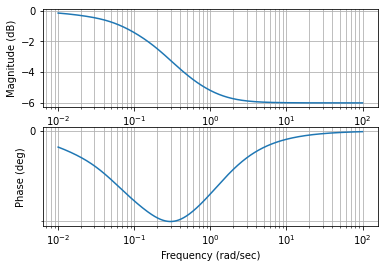

In [5]:
control.bode_plot(sys_theod, omega_limits=[1e-2, 1e2], dB=True);

It can be noted that high input frequencies are damped strongly (-6dB), while low frequences are almost unchanged in mangnitude, just slightly shifted in phase, with medium frequencies mildly damped and strongly shifted in phase.

### The full LTI system
Since the Theodorsen function is the only part of the model that cannot be exactly modeled by a state-space representation, it is possible to construct one for the entire model using the state-space approximation of the Theodorsen function. $\tilde{A}$, $\tilde{B}$, $\tilde{C}$, $\tilde{D}$, provided above. The equations for this LTI system are as follows {cite}`brunton2013empirical`:

$$ \dot{x} = Ax + Bu$$

where:

$$x = \begin{bmatrix}\tilde{x} \\ \dot{h} \\ \alpha \\ \dot{\alpha}\end{bmatrix}$$

$$u = \begin{bmatrix}\ddot{h} \\ \ddot{\alpha}\end{bmatrix}$$

$$A = \begin{bmatrix}\tilde{A} & \tilde{B}C_2 & \tilde{B}C_2 & \tilde{B}C_2(1-2a)/2\\
0 & 0 & 0 & 0\\
0 & 0 & 0 & 1\\
0 & 0 & 0 & 0\\ \end{bmatrix}$$

$$B = \begin{bmatrix}0 & 0\\ 1 & 0\\ 0 & 0\\ 0 & 1\end{bmatrix}$$
$$C = \begin{bmatrix}\tilde{C} & \tilde{D}C_2 & \tilde{D}C_2 & C_1 + \tilde{D}C_2(1-2a)/2\end{bmatrix}$$
$$D = \begin{bmatrix}C_1 & -C_1a\end{bmatrix}$$

In [6]:
dim_theodorsen = sys_theod.nstates
A = np.zeros((dim_theodorsen+3, dim_theodorsen+3))
A[0:dim_theodorsen,0:dim_theodorsen] = A_theod
A[0:dim_theodorsen,dim_theodorsen] = B_theod*C_2
A[0:dim_theodorsen,dim_theodorsen+1] = B_theod*C_2    
A[0:dim_theodorsen,dim_theodorsen+1] = B_theod*C_2*(1-2*a)/2
A[-2, -1] = 1
B = np.zeros((dim_theodorsen+3, 2))
B[dim_theodorsen, 0] = 1
B[-1, -1] = 1
C = np.hstack((C_theod, D_theod*C_2, D_theod*C_2,
               C_1 + D_theod*C_2*(1-2*a)/2))
D = np.array([C_1, -C_1*a])

sys = control.ss(A, B, C, D)

The system has the 4 states of the approximate Theodorsen function, $\tilde{x}$ as well as 3 physically interpretable states: $\dot{h}$, $\alpha$ and $\dot{\alpha}$. It is worth noting that this system is not fully controllable, since the effect of $\dot{h}$ on the flow is de facto the same as the effect of $\dot{h}$ (since plunging at a constant velocity corresponds to a change in apparent angle of attack). The system can be modified to replace both state by the effective angle of attack:

$$\begin{equation}\alpha_e = \alpha + \dot{h} \end{equation}$$

However, in this example this modification is not performed.

It is also possible to split the system into two single-output, single-input (SISO) systems, with $\ddot{h}$ and $\ddot{\alpha}$ as inputs, respectively:

In [7]:
sys_h = control.ss(A, B[:,0], C, D[0])
sys_alpha = control.ss(A, B[:,1], C, D[1])

The Bode plots of both SISO system are also consistent with {cite}`brunton2013empirical`:

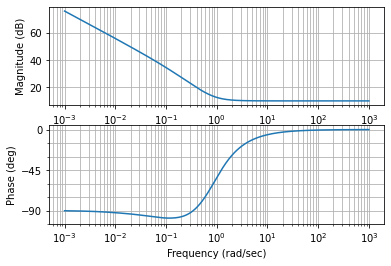

In [8]:
control.bode_plot(sys_h, omega_limits=[1e-3, 1e3], dB=True);

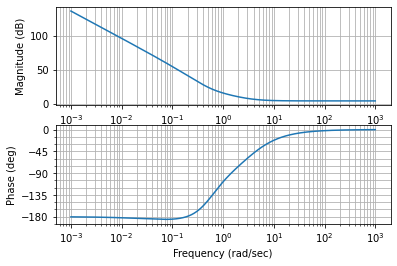

In [9]:
control.bode_plot(sys_alpha, omega_limits=[1e-3, 1e3], dB=True);

## Unsteady lift time responses generated by the model

The Python Control Systems Library allows for easy computing of time responses of LTI systems.

### Impulse in $\ddot{h}$

The first example shall be the response to an $\ddot{h}$ impulse, equivalent to a step change in angle of attack (as discussed before, a change of $\dot{h}$ is equivalent to a change in effective angle of attack $\alpha_e$, therefore an impulse in $\ddot{h}$, corresponding to a step in $\dot{h}$, is equivalent to a step in $\alpha_e$). This is equivalent to the Wagner function, defined as the generalised step response to $\alpha_e$ of the lift {cite}`brunton2013empirical` {cite}`peters2008two` (the only difference being the scaling factor of $C_2 = 2\pi$). The output is compared to an approximation of the Wagner function obtained by Venkatesan & Friedman {cite}`brunton2013empirical`:

E:\Programy\Anaconda\lib\site-packages\control\timeresp.py:1798: UserWarning: System has direct feedthrough: ``D != 0``. The infinite impulse at ``t=0`` does not appear in the output.
Results may be meaningless!
  warnings.warn("System has direct feedthrough: ``D != 0``. The "


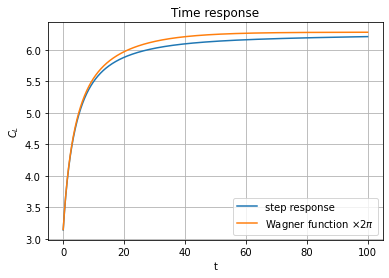

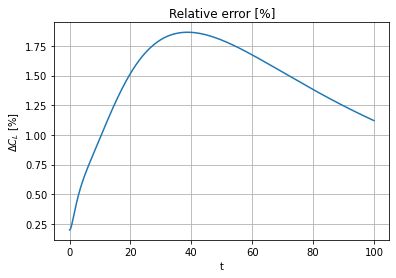

In [10]:
t = np.linspace(0, 100, 1000)
output = control.impulse_response(sys_h, T=t);

wagner = (1 - 0.203*np.exp(-0.072*t)
                     -0.236*np.exp(-0.261*t) - 0.06*np.exp(-0.8*t))

plt.plot(output.time, output.outputs.T, label='step response')
plt.plot(t, C_2*wagner, label='Wagner function $\\times 2\pi$')
plt.title('Time response')
plt.xlabel('t')
plt.ylabel('$C_L$')
plt.legend()
plt.grid()
plt.show()

plt.plot(output.time,
             100*np.abs(output.outputs.T-C_2*wagner)/output.outputs.T)
plt.xlabel('t')
plt.ylabel('$\\Delta C_L$ [%]')
plt.title('Relative error [%]')
plt.grid()
plt.show()

# disregard the warning, the system works correctly

While accurately approximating the Wagner function for different time scales is an active research topic, the simulation above indicates that the LTI Theodorsen model not only replicates a correct step response, but also does so with a quite small relative error (although note that it is being computed with respect to a different approximation, not the true Wagner function).

### Sinusoidal $\ddot{\alpha}$ input

Since the Theodorsen model was derived with harmonic motion in mind, it is natural to see the response of the system to a harmonic input:

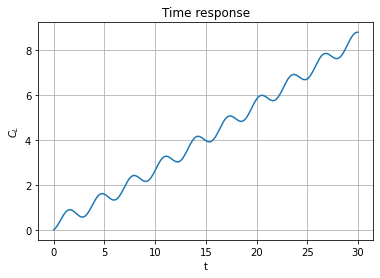

In [11]:
t = np.linspace(0, 30, 300)
omega = 2
amplitude = 0.1
u = amplitude*np.sin(omega*t)
output = control.forced_response(sys_alpha, T=t, U=u);

plt.plot(output.time, output.outputs.T)
plt.title('Time response')
plt.xlabel('t')
plt.ylabel('$C_L$')
plt.grid()
plt.show()

This result may strike as non-physical, since such high values of lift are not attainable. However, it is not the model exhibiting non-physical behaviour; it is the input that is not realistic. Note that since the input is of the form:

$$\begin{equation} u(t) = \ddot{\alpha} = A \sin{(\omega t)} \end{equation}$$

the angle of attack is given by:

$$\begin{equation} \alpha(t) = A  \int_0^t \int_0^T \sin{(\omega \tau)} d\tau dT = \frac{A}{\omega} \int_0^t \left[-\cos{(\omega \tau)} \right]^T_0 dT =\end{equation}$$

$$\begin{equation} = \frac{A}{\omega} \int_0^t \left(-\cos{(\omega T)} + 1 \right) dT = \frac{A}{\omega} \left(-\int_0^t \cos{(\omega T)} dT + \int_0^t 1 dT \right) =\end{equation}$$

$$\begin{equation} = \frac{A}{\omega} \left(-\frac{1}{\omega}\left[\sin{(\omega T)}\right]_0^t + t \right) = \frac{A}{\omega}t - \frac{A}{\omega^2}\sin{(\omega t)} \end{equation}$$

It can be checked that $\alpha$, which is one of the states of the system, indeed evolves this way:

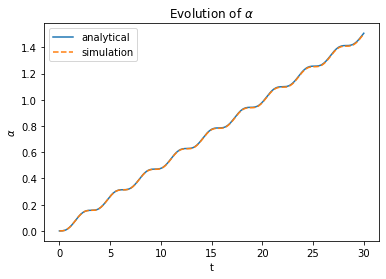

In [12]:
alpha_analytical = amplitude/omega*t - amplitude/omega**2*np.sin(omega*t)

plt.plot(t, alpha_analytical, label='analytical')
plt.plot(output.time, output.states[5], '--', label='simulation')
plt.title('Evolution of $\\alpha$')
plt.xlabel('t')
plt.ylabel('$\\alpha$')
plt.legend()
plt.show()

What follows is that a realistic $\ddot{\alpha}$ is one whose double integral is bounded by realistic values of $\alpha$. A simple way of obtaining this behaviour is changing the phase of the input by $\pi/2$:

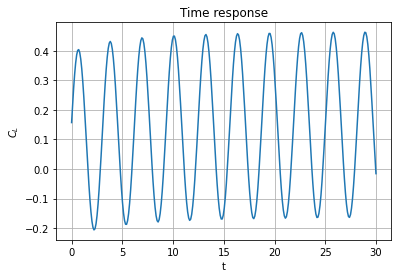

In [13]:
phase = np.pi/2
u = amplitude*np.sin(omega*t+phase)
output = control.forced_response(sys_alpha, T=t, U=u);

plt.plot(output.time, output.outputs.T)
plt.title('Time response')
plt.xlabel('t')
plt.ylabel('$C_L$')
plt.grid()
plt.show()

The response above is realistic. It can be noted that the unsteady lift is not a function of $\alpha$, but rather a hysteresis loop:

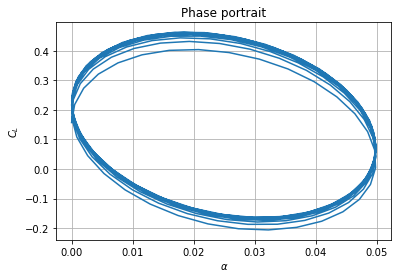

In [14]:
plt.plot(output.states[5], output.outputs.T)
plt.title('Phase portrait')
plt.xlabel('$\\alpha$')
plt.ylabel('$C_L$')
plt.grid()
plt.show()

Another factor that shapes the reponse of the system is the initial state $x_0$. A correctly chosen $x_0$ can also contribute to realistic behaviour of the system. However, this is currently not explored, and the initial values of the state are all assumed to be 0.

### Multi-input response to harmonic $\ddot{\alpha}$ and square $\ddot{h}$ waves

In this final example, it will be demonstrated that the LTI model can generate responses to both input signals ($\ddot{h}$ and $\ddot{\alpha}$), and that arbitrary broadband input can be used as well. The previous sinusoidal pitching input will therefore be combined with a square plunging wave of a different frequency:

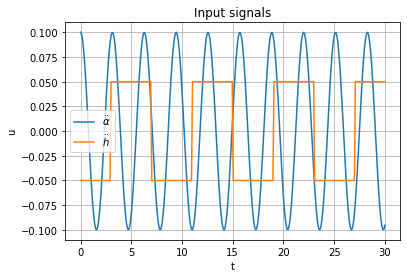

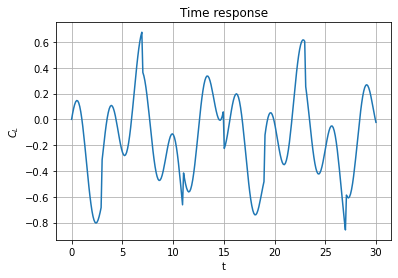

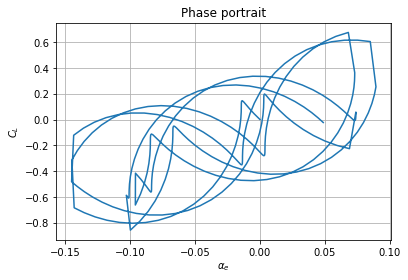

In [15]:
T = 4
phase = T/4
amplitude = 0.05
u_square = -np.array([amplitude if np.floor((ti+phase)/T) %
                   2 == 0 else -amplitude for ti in t])

plt.plot(t, u, label='$\\ddot{\\alpha}$')
plt.plot(t, u_square, label='$\\ddot{h}$')
plt.title('Input signals')
plt.xlabel('t')
plt.ylabel('u')
plt.grid()
plt.legend()
plt.show()

output = control.forced_response(sys, T=t, U=np.vstack((u_square,u)));

plt.plot(output.time, output.outputs.T)
plt.title('Time response')
plt.xlabel('t')
plt.ylabel('$C_L$')
plt.grid()
plt.show()

alpha_e = output.states[4]+output.states[5]
plt.plot(alpha_e, output.outputs.T)
plt.title('Phase portrait')
plt.xlabel('$\\alpha_e$')
plt.ylabel('$C_L$')
plt.grid()
plt.show()

Note that the square signal was chosen to have a periodic integral due to reasons analogous to the choise of phase of $\ddot{\alpha}$.

## Summary

The proposed LTI approximation of the Theodorsen model is able to compute the unsteady lift response to arbitrary input, and does so with decent accuracy (for quantative data, see {cite}`brunton2013empirical` where it was derived). The only "black box" element of the model is the LTI approximation of the Theodorsen function, which was computed in {cite}`brunton2013empirical` using balanced truncation.

The LTI state-space representation of the model offers many advantages, including simple and efficient simulation (due to the numerical properties of linear ODEs) and the possibility of applying system identification tools meant for linear systems. The model of the Theodorsen function can be easily swapped for another one (e.g. one with a smaller dimension).

The code shown in this notebook is purely demonstrative; a library for more intensive work with LTI Theodorsen approximations has already been prepared as well, and is used in different sections of this report:

In [1]:
import Theodorsen_control